우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

프로젝트를 시작하기 전에 주요 라이브러리 버전을 살펴보죠.



# Step1. 검증용 데이터셋 준비
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.



In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import keras_ocr

In [2]:
data_path = os.getenv('HOME') + '/aiffel/ocr_python/images'
data_path

'/aiffel/aiffel/ocr_python/images'

In [5]:
# 입력 이미지 경로 
file_name_list = os.listdir(data_path)
file_path = [data_path + '/' + name for name in file_name_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/images/eng-0 Large.jpeg',
 '/aiffel/aiffel/ocr_python/images/eng-1 Large.jpeg',
 '/aiffel/aiffel/ocr_python/images/kor-2 Large.jpeg',
 '/aiffel/aiffel/ocr_python/images/kor-3 Large.jpeg',
 '/aiffel/aiffel/ocr_python/images/kor-4 Large.jpeg']

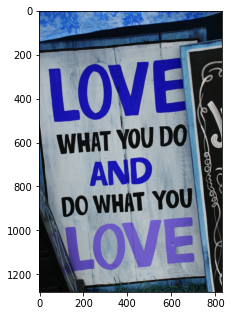

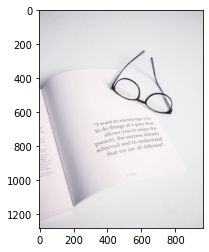

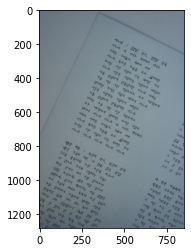

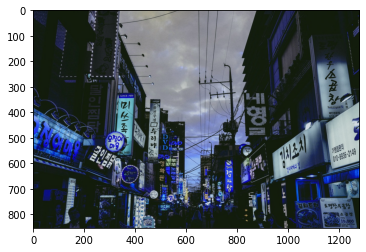

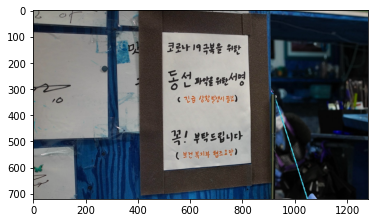

In [8]:
rows = 5
cols = 2
fig = plt.figure(figsize=(30,30))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(rows, cols, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(img)
    
    plt.show()

# Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)
위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

## 2-1. Google OCR API

In [10]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [11]:
# # 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# # 클라우드 환경에서는 무시해도 좋습니다
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS

# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

In [12]:
# for path in file_path:
#     # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
#     detect_text(path)

## 2-2. keras-ocr

In [13]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [14]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

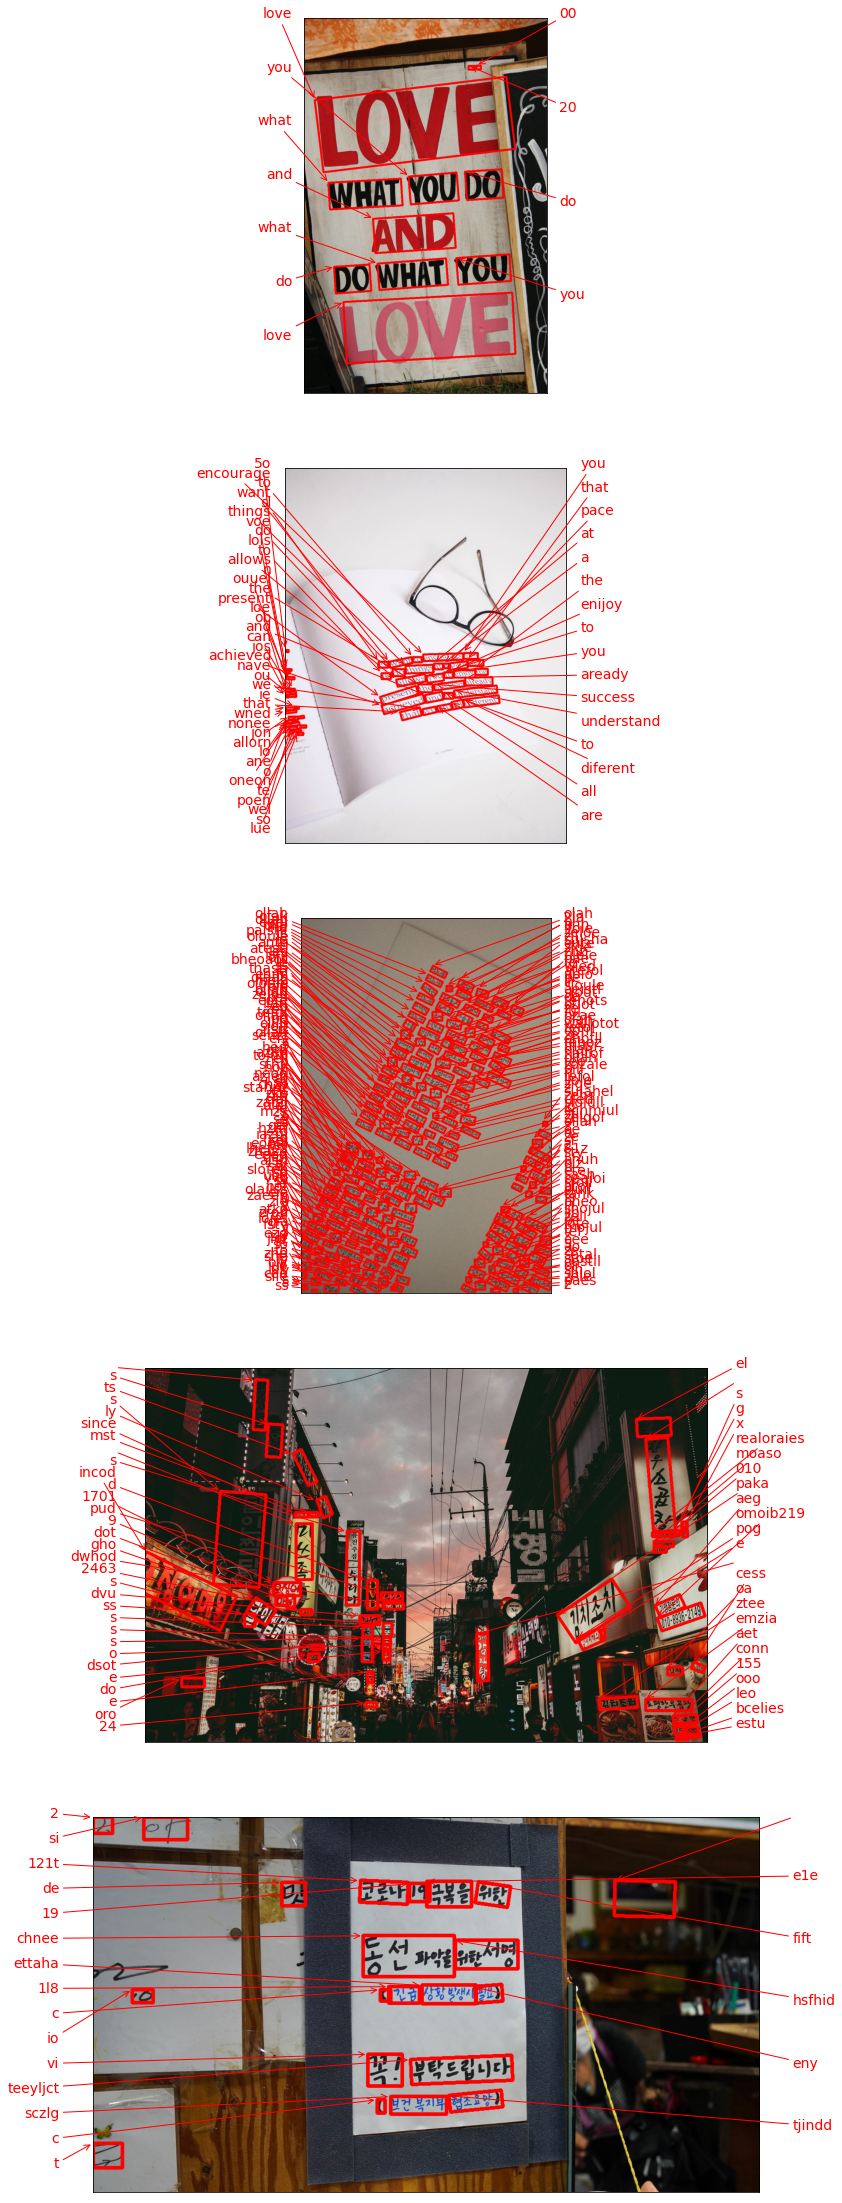

In [16]:
fig, axes = plt.subplots(nrows=len(images), figsize=(40, 40))

for idx, ax in enumerate(axes):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=ax)

## 2-3. Tesseract

In [20]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output', lang='kor'):
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, 
        lang=lang,    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME') + '/aiffel/ocr_python/tesseract/kor'

# tesseract_crop_image_path = crop_word_regions('/aiffel/aiffel/ocr_python/images/2022-11-10_iPhone 11 Pro-6 Large.jpeg', work_dir)


tesseract_crop_image_path = []
for path in file_path:
    cropped_image_path_list = crop_word_regions(path, work_dir)
    tesseract_crop_image_path.append(cropped_image_path_list)

In [30]:
def recognize_images(cropped_image_path_list, lang='kor'):
    custom_oem_psm_config = r' --oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print('Done')
#     return recognized_data


recognize_images(tesseract_crop_image_path[3])

 「      를 1 「 11

Done


In [33]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract/eng'
# tesseract_crop_image_path = crop_word_regions('/aiffel/aiffel/ocr_python/images/2022-11-10_iPhone 11 Pro-5 Large.jpeg', work_dir)
tesseract_result_path = []

for path in file_path:
    image_path_list = crop_word_regions(path, work_dir, lang='eng')
    tesseract_result_path.extend(image_path_list)

recognize_images(tesseract_crop_image_path[1], lang='eng')

= | k , : a


ae


VCOULAYS

‘

YAN

Ant LO

Cc

9 AO


aN

a Dace

=

Wat

a\\OW>

i.

XO

S

EMO


Ae

E

.e

VAC Ce SS

a\

x

a

a

N

sere

ack

\>

.

a

A

A

Ana

o unde

¥S

XO

mS.

We

Ate

—

~\

aAierent

(no

Done


# Step3. 테스트 결과 정리
모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

In [34]:
# 세 모델을 비교할 수 있는 함수
def ocr_model_comparison(img_idx):
    print('Original image:')
    img = cv2.imread(file_path[img_idx], cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.show()
    
#     print('Google OCR API result:\n')
#     detect_text(file_path[img_idx])

    print('Tesseract result:\n')
    work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract/'+str(img_idx)
    cropped_image_path = crop_word_regions(file_path[img_idx], work_dir)
    recognize_images(cropped_image_path)
        
    print('keras-ocr result:\n')
    keras_ocr.tools.drawAnnotations(image=images[img_idx], predictions=prediction_groups[img_idx][0])

영어, 프랑스어, 한국어 각각 한장씩 비교해봅니다. (1, 5, 8번째 사진)

Original image:


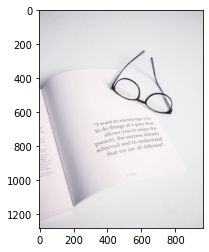

Tesseract result:


   - 、 , [ 해

0.


나노 로

기

(6 도 지니

그도 1

그

&


이엘

~

로

수 노지 아족.

01 =

"

녹 (

로

나

|

노노

톱

은

0 스22

수

나

으.

시

이

22으

26600

는

열

-

(

(

31

어

~

노은

66

<

2

ㄷㄷ

세

그니까

나

Done
keras-ocr result:



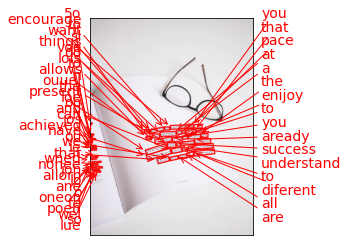

In [35]:
ocr_model_comparison(1)

Original image:


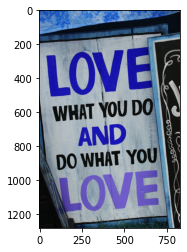

Tesseract result:

바

Done
keras-ocr result:



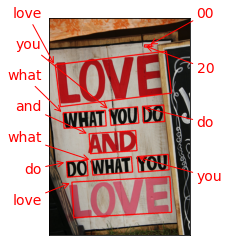

In [41]:
ocr_model_comparison(0)

Original image:


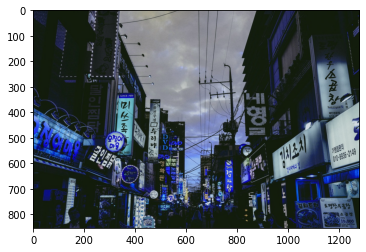

Tesseract result:


Done
keras-ocr result:



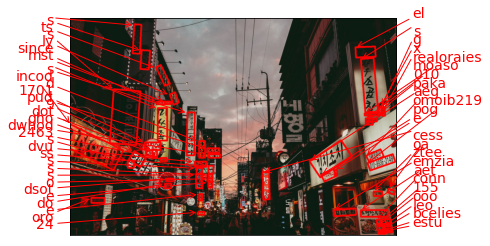

In [39]:
ocr_model_comparison(3)

Original image:


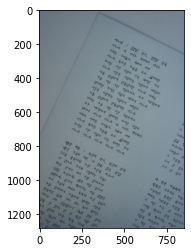

Tesseract result:



Done
keras-ocr result:



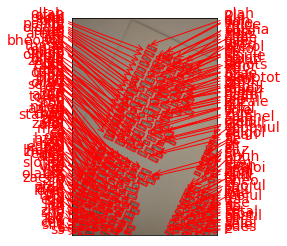

In [38]:
ocr_model_comparison(2)

# Step4. 결과 분석과 결론 제시
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.




한글과 영어로 된 문자들을 제대로 인식하는지 확인해보았다

1. Google OCR API : 구글 Cloud vision API key 생성이 안되어 실험하지 못했음
2. keras-ocr : 영문은 인식을 잘하는데 한글은 인식하지 못하였다
3. Tesseract : 영문과 한글을 각각 따로 지정해줘야 했다. 영문과 한글이 동시에 있는 사진에서는 다른 한 언어는 제대로 인식하지 못하였으며 하나의 각각의 인식률 또한 좋지 못하였다

# Step 5. 회고

In [ ]:
- 여러 오류가 발생하여 제대로 진행하지 못하였다. 스택오버플로우에 검색해도 원인을 알수는 있었으나 이 프로젝트에서 그 원인을 해결하는 방법을 알 수없었다.
오류를 해결하는 능력이 아직 없다보니 이 프로젝트을 제대로 완수하지 못하였다
- 테서레트에서 한글로 지정했음에도 한글을 제대로 인식하지 못하였다. 왜 그런지 좀더 알아봐야겠다